In [135]:
import os
import sys
import pandas as pd
import googletrans
from googletrans import Translator
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
import numpy as np
from sklearn.model_selection import GridSearchCV


In [136]:
# Constants
ROOT_PATH = os.path.abspath(os.getcwd())
SEED = 170

# bycode 2018 excel
BYCODE = "bycode2018"

# index 2018 excel
INDEX = "index 2018"
NATURAL = "Natural Area"
DISTRICT = "District"
RELIGION = "Religion"
SETTLEMENT_TYPE = "Settlement Type"


# elections data
CALPI = "calpi"
SETTELMENT = "settelments"


In [137]:
def inner_join(df_1,df_2,column_name):
    """makes inner-join between dataframes on the specified column"""
    return pd.merge(left=df_1, right=df_2, left_on= column_name, right_on=column_name)

def get_index(sheet):
    "returns dataframe of sheet from index 2018 excel"
    path = os.path.join(ROOT_PATH,INDEX+".xlsx")
    return pd.read_excel(path, sheet_name=sheet)

def get_bycode():
    """returns dataframe for bycode excel"""
    path = os.path.join(ROOT_PATH,BYCODE+".xlsx")
    return pd.read_excel(path)

def get_data(agg_type, num):
    """returns dataframe of the requested .xlsx""" 
    if type(num) is not str:
        num = str(num)
        
    path = os.path.join(ROOT_PATH,num+agg_type+".xlsx")
    return pd.read_excel(path,dtype=object)

In [138]:
def remove_small_parties(df,threshold):
    """remove parties that didnt pass the threshold"""
    
    for column in df.columns[7:]:
            if df[column].sum() < threshold:
                   df = df.drop(column,axis=1)
    return df

In [139]:
def total_voters(df):
    "ploting a barchar from dataframe"
    dict={}
    for c in df.columns[7:]:
        dict[c]=(df[c].sum()/df['valid votes'].sum())*100
    plt.figure(figsize=(20,10))
    plt.bar(range(len(dict)), list(dict.values()), align='center')
    plt.ylabel('Voter turnout')
    plt.xlabel('Parties')
    plt.xticks(range(len(dict)), list(dict.keys()))
    plt.show()

In [140]:
def unite_parties (df):
    """ unites small parties to factions
    
    We think those factions represent the israeli society
    """
    
    d={'United Torah Judaism':'Haredi','Shas':'Haredi', 'Avoda':'Left','Meretz':'Left',
       'Consolidation of right-wing parties':'Right','Kolano':'Right','Israel is our Home':'Right','New Right':'Right',
        'UAL-Balad':'Arab','Hadash':'Arab' ,'Gesher Avoda':'Left','Joint list':'Arab','right':'Right'
        ,'Avoda-Meretz-Gesher':'Left'}
    
    faction=['Haredi','Right','Arab','Left']
    for f in faction:
        df.insert(len(df.columns),f ,0)
    for c in  df.columns[7:]:
        if c in d:
            s=df[d[c]]+df[c]
            df[d[c]]=s
   
    for c in d.keys():
        if c in df.columns:
              df=df.drop(c,axis=1)
    return df

In [141]:
def normalize_to_voting_ratios(df):
    """normalizing the votes according to proportion of votes per party"""
    
    for i,r in df.iterrows():
        for c in df.columns[7:]:
            x = r[c]/r['valid votes']
            df.at[i , c]=x
    
    colms_to_remove = ["name","Holders of voting rights","Voters","Disqualified","valid votes","committee code"]
    df = df.drop(labels = colms_to_remove,axis=1) 
    return df

In [142]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ 
    Returns the angle in radians between vectors 'v1' and 'v2'
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def prepare_vectors(df):
    """calculates the distance and the angle if each vector from the base_vector"""
    
    matrix = [] 
    vector_base = np.zeros(df.shape[1])
    vector_base.fill(1)
    print(df.shape)

    for row in df:
        dist = np.linalg.norm(row)
        angle = angle_between(vector_base,row)
        matrix.append([dist,angle])
        
    return np.array(matrix)
    

In [165]:
def add_most_voted_colm(df):
    """ adds a column of labels for the most voted faction """
    temp = df.copy()
    temp.drop(labels = ["code"],axis=1,inplace = True)
    
    for c in temp.columns:
        temp[c] = pd.to_numeric(temp[c])
    
    colm = temp.idxmax(axis=1)
    df["chosen"] = colm
    return df
        

In [169]:
df_21 = get_data(SETTELMENT,21)
df_21 = remove_small_parties(df_21,135720)
df_21 = unite_parties(df_21)
df_21 = normalize_to_voting_ratios(df_21)
df_21 = add_most_voted_colm(df_21)
vectors = df_21[df_21.columns.difference(['code','chosen'])]

In [170]:
param = {
    "n_clusters":[3,4,5],
    "init":["k-means++", "random"],
    "n_init": [10],
    "max_iter":[300],
    "precompute_distances":[False,True],
    "random_state":[SEED],
    "algorithm" : ["auto", "full", "elkan"]

}

gs = GridSearchCV(KMeans(), param,  refit=True, cv=[(slice(None), slice(None))], verbose=1)
gs.fit(vectors)
model = gs.best_estimator_

Fitting 1 folds for each of 36 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    1.4s finished


In [219]:
labels = model.labels_
df_21['Cluster Class'] = pd.Series(labels, index=df_21.index)
agg = df_21.groupby(['Cluster Class'])["chosen"].value_counts()    

In [238]:
df = pd.read_csv("https://github.com/selva86/datasets/raw/master/mpg_ggplot2.csv")
df_21

,code,Likud,Blue and white,Haredi,Right,Arab,Left,chosen,Cluster Class
0,7,0.380054,0.266846,0.0943396,0.140162,0,0.0700809,Likud,0
1,10,0.52766,0.0212766,0.323404,0.0978723,0,0.0212766,Likud,0
2,11,0.291667,0.385417,0.00694444,0.128472,0,0.107639,Blue and white,1
3,13,0.0645161,0.620347,0.00992556,0.0843672,0,0.151365,Blue and white,1
4,15,0.767442,0.0232558,0.134884,0.0372093,0,0.00465116,Likud,0
...,...,...,...,...,...,...,...,...,...
1209,9500,0.345736,0.348962,0.0311208,0.15515,0.000545182,0.0561992,Blue and white,0
1210,9600,0.42007,0.206444,0.0320774,0.251161,0.000622397,0.0283909,Likud,0
1211,9700,0.204511,0.536063,0.0203736,0.0696552,0.00126437,0.121925,Blue and white,1
1212,9800,0.183213,0.507934,0.0119344,0.0754098,0.00314754,0.166557,Blue and white,1


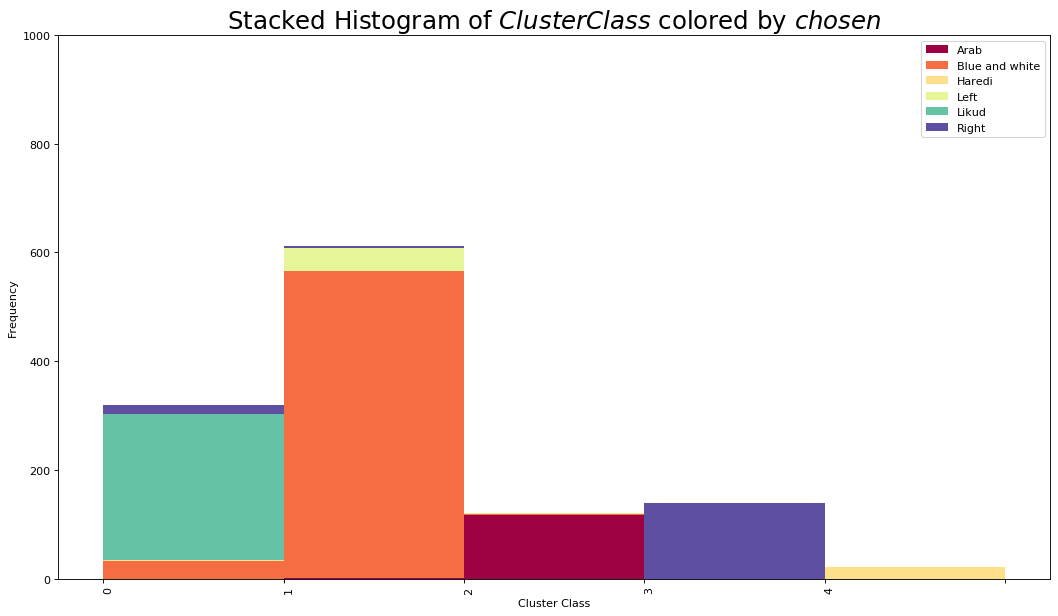

In [259]:


# Prepare data
x_var = 'Cluster Class'
groupby_var = 'chosen'
df_agg = df_21.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [df_21[x_var].values.tolist() for i, df_21 in df_agg]

# Draw
plt.figure(figsize=(16,9), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, df_21[x_var].unique().__len__(), stacked=True, density=False, color=colors[:len(vals)])

# Decoration
plt.legend({group:col for group, col in zip(np.unique(df_21[groupby_var]).tolist(), colors[:len(vals)])})
plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")
plt.ylim(0, 1000)
plt.xticks(ticks=bins, labels=np.unique(df_21[x_var]).tolist(), rotation=90, horizontalalignment='left')
plt.show()

<Figure size 1440x720 with 0 Axes>

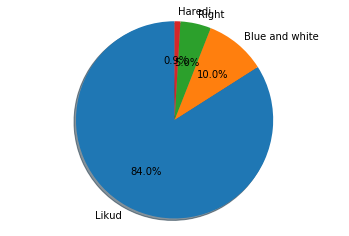

<Figure size 1440x720 with 0 Axes>

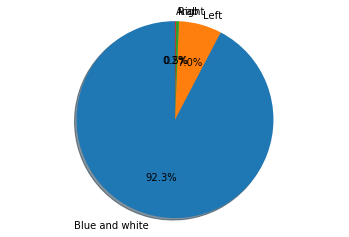

<Figure size 1440x720 with 0 Axes>

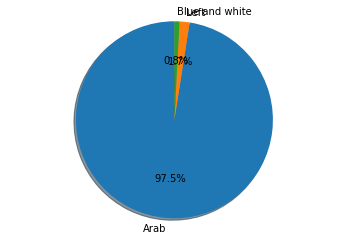

<Figure size 1440x720 with 0 Axes>

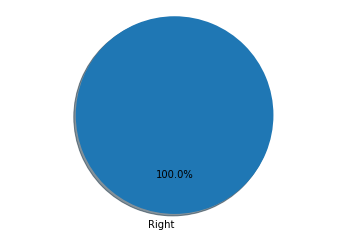

<Figure size 1440x720 with 0 Axes>

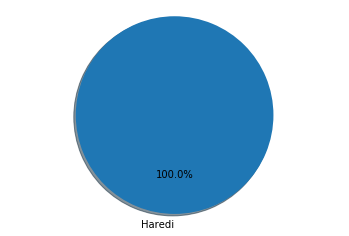

In [233]:
labels_p = [] 
sizes = []

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
for cluster in np.unique(labels):
    for label,value in agg[cluster].items():
        labels_p.append(label)
        sizes.append(value)
        
    plt.figure(figsize=(20,10))
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels_p, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    labels_p.clear()
    sizes.clear()
plt.show()

In [ ]:

plt.figure(figsize=(20,10))
plt.scatter(vectors[:,0],vectors[:,1],c=y)
plt.title("Incorrect Number of Blobs")

In [ ]:
df_bycode = get_bycode()
types = get_index(SETTLEMENT_TYPE)
bycode_ele = inner_join(df_21,df_bycode,"code")
super_df =  inner_join(bycode_ele,types,"Settlement type code")
settelments = super_df["Settlement type"].values